# Importing Libraries

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time

from PIL import Image
from matplotlib import pyplot as plt

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.0+cu101


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing Training and Test Sets

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/content/drive/My Drive/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB') #if you wanted to make CNN from scratch you don't need to add RGB part
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),#this is for a little bit of augmentation
    torchvision.transforms.ToTensor(),#convert to tensor model
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#normalized based on this network
])
#since we are using pretrain model we need to convert images to the size network accept
# we don't do augmentation on test set
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
new_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [ ]:
train_dirs = {
    'normal': '/content/drive/My Drive/COVID-19 Radiography Database/normal',
    'viral': '/content/drive/My Drive/COVID-19 Radiography Database/viral',
    'covid': '/content/drive/My Drive/COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1283 normal examples
Found 1286 viral examples
Found 160 covid examples


In [ ]:
test_dirs = {
    'normal': '/content/drive/My Drive/COVID-19 Radiography Database/test/normal',
    'viral': '/content/drive/My Drive/COVID-19 Radiography Database/test/viral',
    'covid': '/content/drive/My Drive/COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
new_test_dirs = {
    'normal': '/content/drive/My Drive/COVID-19 Radiography Database/new_test/normal',
    'viral': '/content/drive/My Drive/COVID-19 Radiography Database/new_test/viral',
    'covid': '/content/drive/My Drive/COVID-19 Radiography Database/new_test/covid'
}

new_test_dataset = ChestXRayDataset(new_test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dl_new_test = torch.utils.data.DataLoader(new_test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))
print('Number of test batches', len(dl_new_test))


Number of training batches 455
Number of test batches 15
Number of test batches 15


# Data Visualization

In [ ]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean # denormalize
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

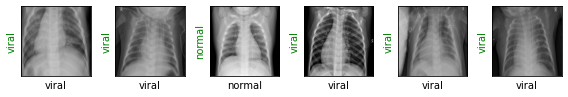

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

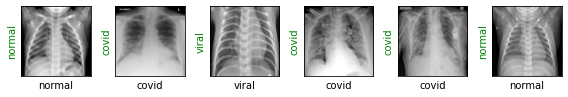

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Confusion Matrix Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Creating Resnet18 Model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

#print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss() #since we use it for classification 
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds_resnet18():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

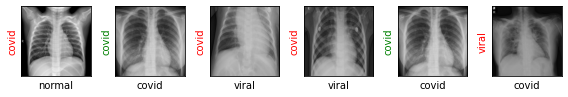

In [ ]:
show_preds_resnet18()

# Training the Model

In [ ]:
def train_resnet18(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.
        pred_vec = np.array([])
        labels_vec = np.array([])

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    pred_vec = np.concatenate([pred_vec,preds])
                    labels_vec = np.concatenate([labels_vec,labels])

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds_resnet18()

                resnet18.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return pred_vec, labels_vec
                pred_vec = np.array([])
                labels_vec = np.array([])

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.1051, Accuracy: 1.0000


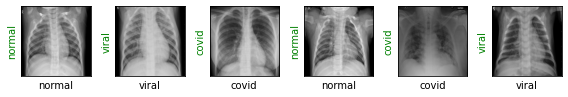

Performance condition satisfied, stopping..
CPU times: user 12.4 s, sys: 349 ms, total: 12.7 s
Wall time: 13.8 s


In [ ]:
%%time

pred_vec, labels_vec = train_resnet18(epochs=1)

In [ ]:
val_loss = 0.

p_v_resnet18 = np.array([])
l = np.array([])
accuracy_resnet18 = 0

for val_step, (images, labels) in enumerate(dl_new_test):
                    

                    outputs_resnet18 = resnet18(images)
                    _, preds_resnet18 = torch.max(outputs_resnet18, 1)
                    accuracy_resnet18 += sum((preds_resnet18 == labels).numpy())
                    p_v_resnet18 = np.concatenate([p_v_resnet18,preds_resnet18])
                    #labels_vec_resnet18 = np.concatenate([labels_vec_resnet18,labels])
                    l = np.concatenate([l,labels])


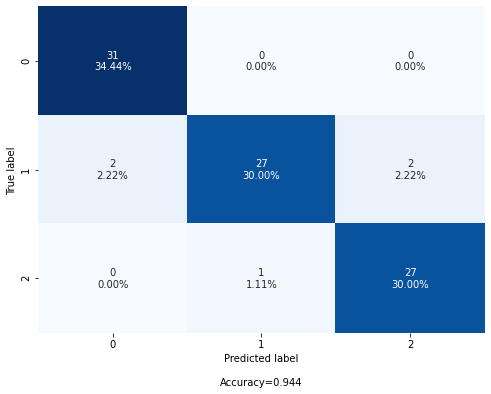

In [ ]:
cf = confusion_matrix(l, p_v_resnet18, labels=[0, 1, 2])
 
make_confusion_matrix(cf ,figsize=(8,6), cbar=False)

# Resnet 18 Final Results

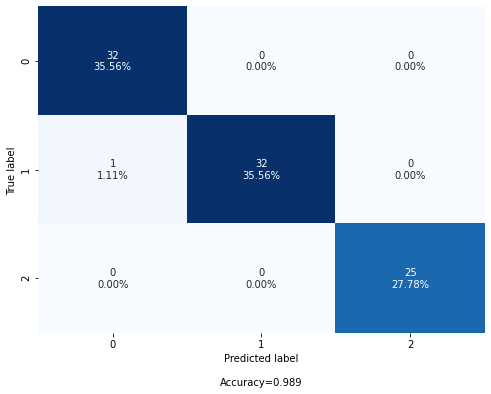

In [ ]:
cf_matrix_3x3 = confusion_matrix(labels_vec, pred_vec, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_3x3 ,figsize=(8,6), cbar=False)

# Resnet34 Model

In [ ]:
resnet34 = torchvision.models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
resnet34.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss() #since we use it for classification 
optimizer = torch.optim.Adam(resnet34.parameters(), lr=3e-5)

In [ ]:
def show_preds_resnet34():
    resnet34.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet34(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

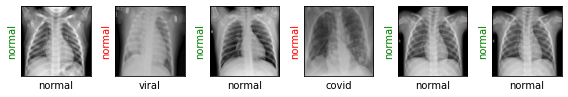

In [ ]:
show_preds_resnet34()

#Training the Model

In [ ]:
def train_resnet34(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.
        pred_vec = np.array([])
        labels_vec = np.array([])

        resnet34.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet34(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet34.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet34(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    pred_vec = np.concatenate([pred_vec,preds])
                    labels_vec = np.concatenate([labels_vec,labels])

                
                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                
                show_preds_resnet34()

                resnet34.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return pred_vec, labels_vec
                pred_vec = np.array([])
                labels_vec = np.array([])

        train_loss /= (train_step + 1)


        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.1120, Accuracy: 1.0000


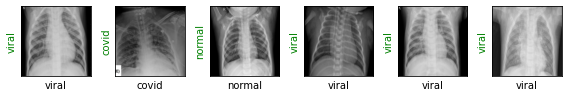

Performance condition satisfied, stopping..
CPU times: user 19.9 s, sys: 426 ms, total: 20.3 s
Wall time: 22 s


In [ ]:
%%time
pred_vec_resnet34, labels_vec_resnet34 = train_resnet34(epochs=1)

#Resnet34 Final Results

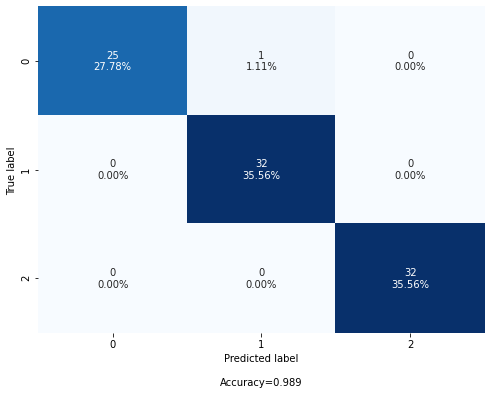

In [ ]:
cf_matrix_3x3_resnet34 = confusion_matrix(labels_vec_resnet34, pred_vec_resnet34, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_3x3_resnet34 ,figsize=(8,6), cbar=False)

#Alexnet Model

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
alexnet.classifier[6] = nn.Linear(in_features=4096,out_features=3)
loss_fn = torch.nn.CrossEntropyLoss() #since we use it for classification 
optimizer = torch.optim.Adam(alexnet.parameters(), lr=3e-5)

In [ ]:
def show_preds_alexnet():
    alexnet.eval()
    images, labels = next(iter(dl_test))
    outputs = alexnet(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

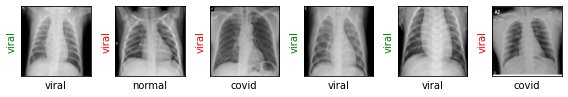

In [ ]:
show_preds_alexnet()

In [ ]:
def train_alexnet(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.
        pred_vec = np.array([])
        labels_vec = np.array([])


        alexnet.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = alexnet(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                alexnet.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = alexnet(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    pred_vec = np.concatenate([pred_vec,preds])
                    labels_vec = np.concatenate([labels_vec,labels])

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds_alexnet()

                alexnet.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return pred_vec, labels_vec
                pred_vec = np.array([])
                labels_vec = np.array([])

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.1278, Accuracy: 0.9556


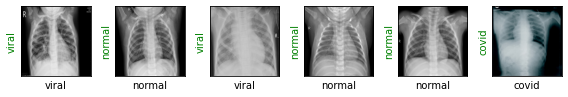

Evaluating at step 20
Validation Loss: 0.0725, Accuracy: 0.9667


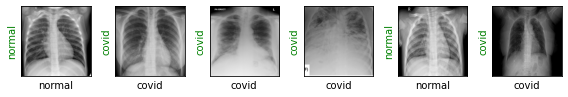

Evaluating at step 40
Validation Loss: 0.1552, Accuracy: 0.9444


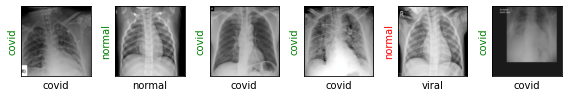

Evaluating at step 60
Validation Loss: 0.0523, Accuracy: 0.9778


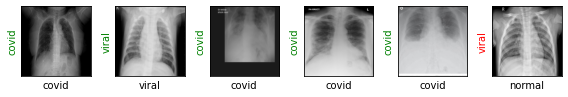

Evaluating at step 80
Validation Loss: 0.1710, Accuracy: 0.9444


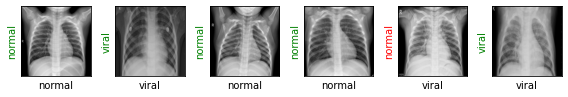

Evaluating at step 100
Validation Loss: 0.0435, Accuracy: 0.9778


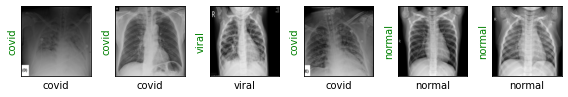

Evaluating at step 120
Validation Loss: 0.1017, Accuracy: 0.9778


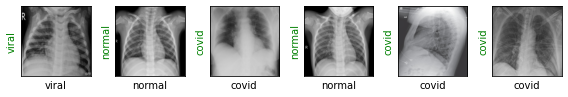

Evaluating at step 140
Validation Loss: 0.0992, Accuracy: 0.9556


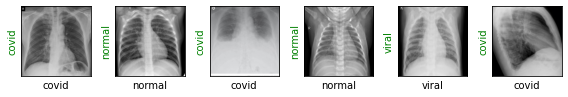

Evaluating at step 160
Validation Loss: 0.1337, Accuracy: 0.9556


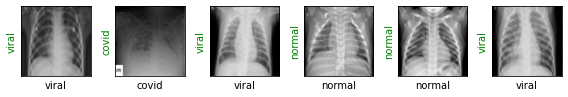

Evaluating at step 180
Validation Loss: 0.1020, Accuracy: 0.9667


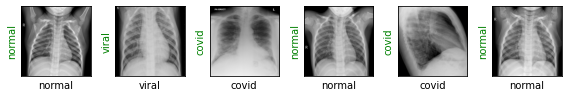

Evaluating at step 200
Validation Loss: 0.0685, Accuracy: 0.9778


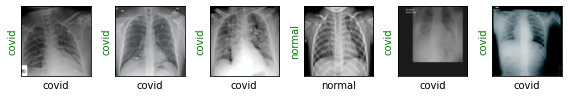

Evaluating at step 220
Validation Loss: 0.1047, Accuracy: 0.9556


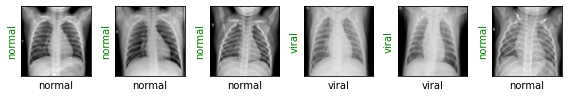

Evaluating at step 240
Validation Loss: 0.0504, Accuracy: 0.9889


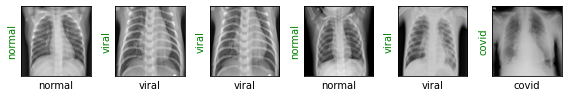

Performance condition satisfied, stopping..
CPU times: user 6min 28s, sys: 5.05 s, total: 6min 33s
Wall time: 9min 13s


In [ ]:
%%time

pred_vec_alexnet, labels_vec_alexnet = train_alexnet(epochs=1)

# Alexnet Final Result

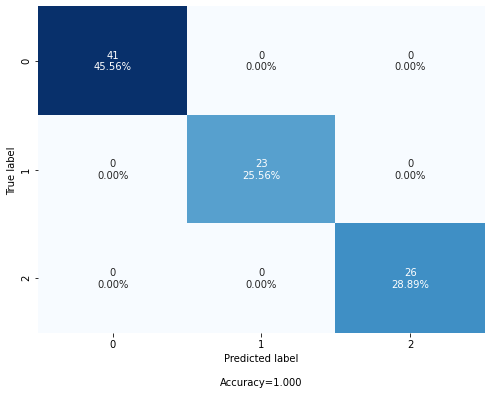

In [ ]:
cf_matrix_3x3_alexnet = confusion_matrix(labels_vec_alexnet, pred_vec_alexnet, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_3x3_alexnet ,figsize=(8,6), cbar=False)


#Squeeznet Model



In [ ]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


In [ ]:
squeezenet.classifier[1] = nn.Conv2d(512, 3, kernel_size=(1,1), stride=(1,1))
loss_fn = torch.nn.CrossEntropyLoss() #since we use it for classification 
optimizer = torch.optim.Adam(squeezenet.parameters(), lr=3e-5)

In [ ]:
def show_preds_squeezenet():
    squeezenet.eval()
    images, labels = next(iter(dl_test))
    outputs = squeezenet(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

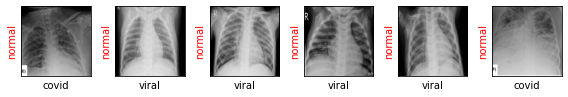

In [ ]:
show_preds_squeezenet()

#Train the model

In [ ]:
def train_squeezenet(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.
        pred_vec = np.array([])
        labels_vec = np.array([])

        squeezenet.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = squeezenet(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                squeezenet.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = squeezenet(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    pred_vec = np.concatenate([pred_vec,preds])
                    labels_vec = np.concatenate([labels_vec,labels])

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds_squeezenet()

                squeezenet.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return pred_vec, labels_vec
                pred_vec = np.array([])
                labels_vec = np.array([])

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.1135, Accuracy: 0.9667


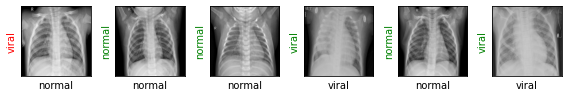

Performance condition satisfied, stopping..
CPU times: user 9.3 s, sys: 256 ms, total: 9.56 s
Wall time: 9.6 s


In [ ]:
%%time

pred_vec_squeezenet, labels_vec_squeezenet = train_squeezenet(epochs=1)

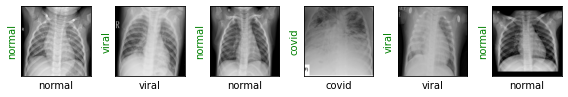

In [ ]:
show_preds_squeezenet()

#Final Result

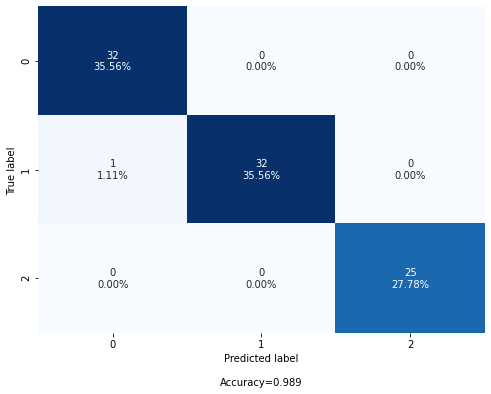

In [ ]:
cf_matrix_3x3_squeezenet = confusion_matrix(labels_vec_squeezenet, pred_vec_squeezenet, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_3x3 ,figsize=(8,6), cbar=False)

#VGG16 Model

In [ ]:
vgg16 = torchvision.models.vgg16_bn()

In [ ]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False
# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 3)]) # Add our layer with 3 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

In [ ]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")

In [ ]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
loss_fn_vgg = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

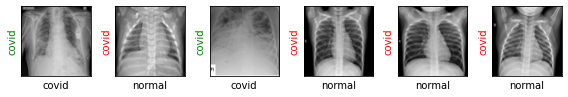

In [ ]:
def show_preds_vgg16():
    vgg16.eval()
    images, labels = next(iter(dl_test))
    outputs = vgg16(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

show_preds_vgg16()

In [ ]:
def train_vgg(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.
        pred_vec = np.array([])
        labels_vec = np.array([])

        vgg16.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer_ft.zero_grad()
            outputs = vgg16(images)
            loss = loss_fn_vgg(outputs, labels)
            loss.backward()
            optimizer_ft.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                vgg16.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = vgg16(images)
                    loss = loss_fn_vgg(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    pred_vec = np.concatenate([pred_vec,preds])
                    labels_vec = np.concatenate([labels_vec,labels])

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds_vgg16()

                vgg16.train()

                if accuracy >= 0.90:
                    print('Performance condition satisfied, stopping..')
                    return pred_vec, labels_vec
                pred_vec = np.array([])
                labels_vec = np.array([])

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [ ]:
#show_preds_vgg16()

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.0986, Accuracy: 0.3222


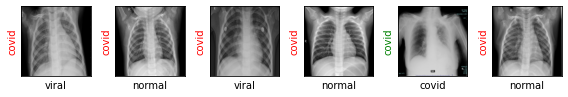

Evaluating at step 20
Validation Loss: 2.5231, Accuracy: 0.3778


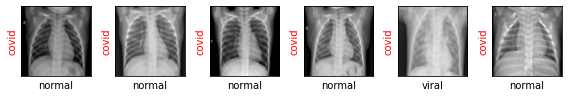

Evaluating at step 40
Validation Loss: 27.1825, Accuracy: 0.3556


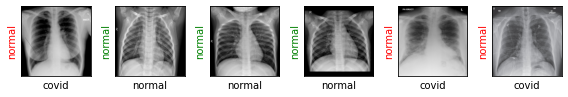

Evaluating at step 60
Validation Loss: 9.6941, Accuracy: 0.3222


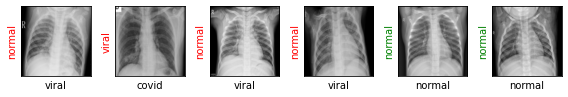

Evaluating at step 80
Validation Loss: 2.8072, Accuracy: 0.5889


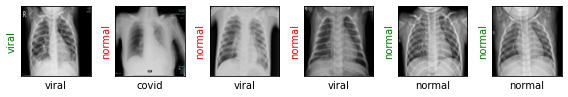

Evaluating at step 100
Validation Loss: 1.2004, Accuracy: 0.6333


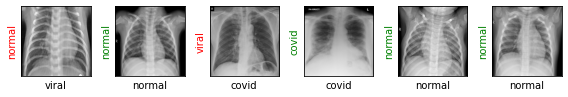

Evaluating at step 120
Validation Loss: 2.5041, Accuracy: 0.3556


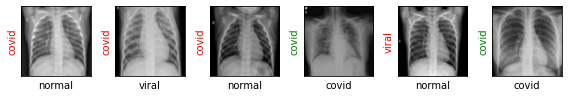

Evaluating at step 140
Validation Loss: 0.6375, Accuracy: 0.7444


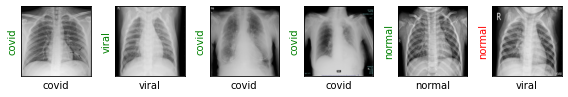

Evaluating at step 160
Validation Loss: 1.1061, Accuracy: 0.6778


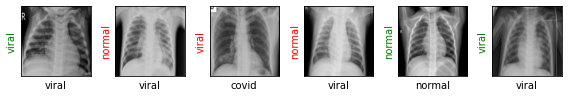

Evaluating at step 180
Validation Loss: 0.5505, Accuracy: 0.7889


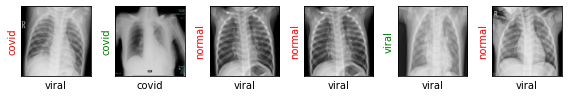

Evaluating at step 200
Validation Loss: 0.5434, Accuracy: 0.8000


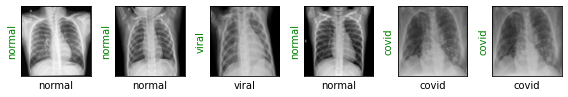

Evaluating at step 220
Validation Loss: 0.5296, Accuracy: 0.8556


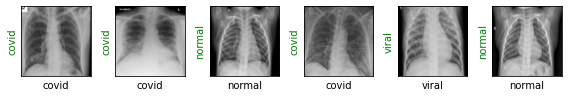

Evaluating at step 240
Validation Loss: 0.7042, Accuracy: 0.7667


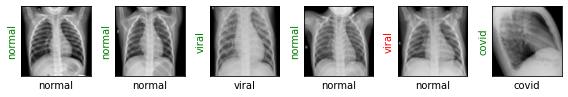

Evaluating at step 260
Validation Loss: 0.4117, Accuracy: 0.8667


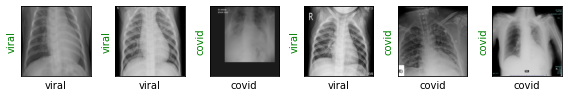

Evaluating at step 280
Validation Loss: 0.4213, Accuracy: 0.8222


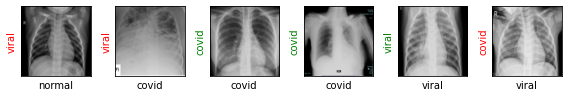

Evaluating at step 300
Validation Loss: 0.6422, Accuracy: 0.8000


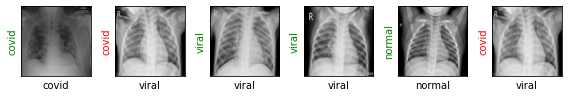

Evaluating at step 320
Validation Loss: 0.6720, Accuracy: 0.7444


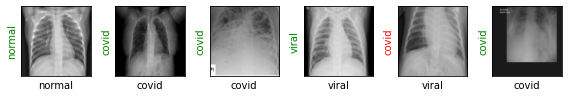

Evaluating at step 340
Validation Loss: 0.4185, Accuracy: 0.9111


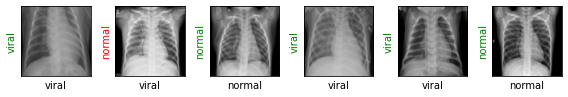

Performance condition satisfied, stopping..
CPU times: user 1h 23min 39s, sys: 41.2 s, total: 1h 24min 20s
Wall time: 1h 25min 45s


In [ ]:
%%time
pred_vec_vgg16, labels_vec_vgg16 = train_vgg(epochs=1)

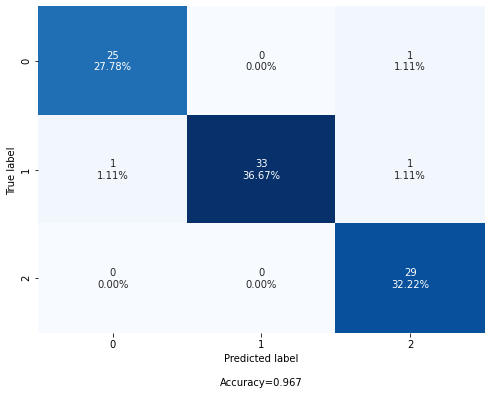

In [ ]:
cf_matrix_3x3_vgg = confusion_matrix(labels_vec_vgg16, pred_vec_vgg16, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_3x3_vgg ,figsize=(8,6), cbar=False)

# Test the models on test dataset

In [ ]:
val_loss = 0.

p_v_resnet18 = np.array([])

p_v_resnet34 = np.array([])

p_v_alexnet = np.array([])

p_v_squeezenet = np.array([])

p_v_vgg = np.array([])


l = np.array([])

accuracy_vgg = 0
accuracy_resnet18 = 0
accuracy_resnet34 = 0
accuracy_alexnet = 0
accuracy_squeezenet = 0

for val_step, (images, labels) in enumerate(dl_new_test):
                    outputs_vgg = vgg16(images)
                    _, preds_vgg = torch.max(outputs_vgg, 1)
                    accuracy_vgg += sum((preds_vgg == labels).numpy())
                    p_v_vgg = np.concatenate([p_v_vgg,preds_vgg])

                    outputs_resnet18 = resnet18(images)
                    _, preds_resnet18 = torch.max(outputs_resnet18, 1)
                    accuracy_resnet18 += sum((preds_resnet18 == labels).numpy())
                    p_v_resnet18 = np.concatenate([p_v_resnet18,preds_resnet18])

                    outputs_resnet34 = resnet34(images)
                    _, preds_resnet34 = torch.max(outputs_resnet34, 1)
                    accuracy_resnet34 += sum((preds_resnet34 == labels).numpy())
                    p_v_resnet34 = np.concatenate([p_v_resnet34,preds_resnet34])              

                    outputs_alexnet = alexnet(images)
                    _, preds_alexnet = torch.max(outputs_alexnet, 1)
                    accuracy_alexnet += sum((preds_alexnet == labels).numpy())
                    p_v_alexnet = np.concatenate([p_v_alexnet,preds_alexnet])

                    outputs_squeezenet = squeezenet(images)
                    _, preds_squeezenet = torch.max(outputs_squeezenet, 1)
                    accuracy_squeezenet += sum((preds_squeezenet == labels).numpy())
                    p_v_squeezenet = np.concatenate([p_v_squeezenet,preds_squeezenet])
                    l = np.concatenate([l,labels])


#Resnet34 confusion matrix

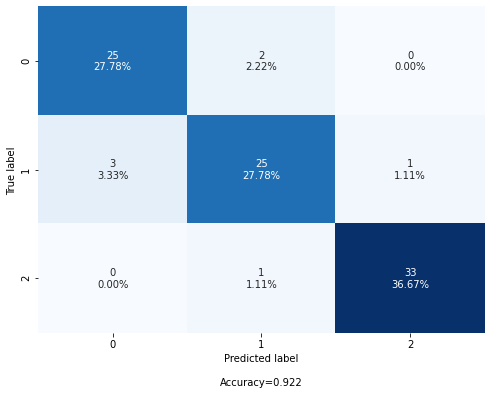

In [ ]:
cf_matrix_resnet34 = confusion_matrix(l, p_v_resnet34, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_resnet34 ,figsize=(8,6), cbar=False)

#Resnet18 confusion matrix

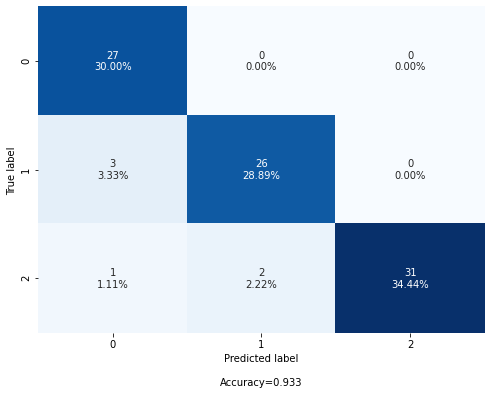

In [ ]:
cf_matrix_resnet18 = confusion_matrix(l, p_v_resnet18, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_resnet18 ,figsize=(8,6), cbar=False)

#Alextnet confusion matrix

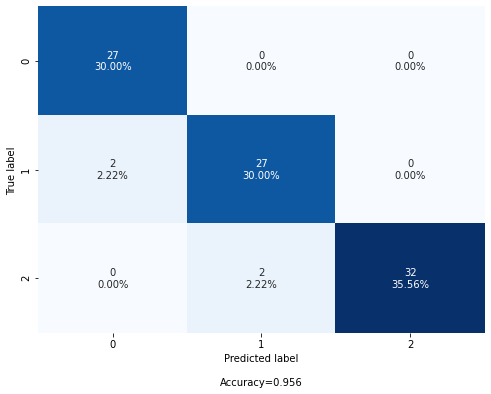

In [ ]:
cf_matrix_alexnet = confusion_matrix(l, p_v_alexnet, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_alexnet ,figsize=(8,6), cbar=False)

#Squeezenet confusion matrix

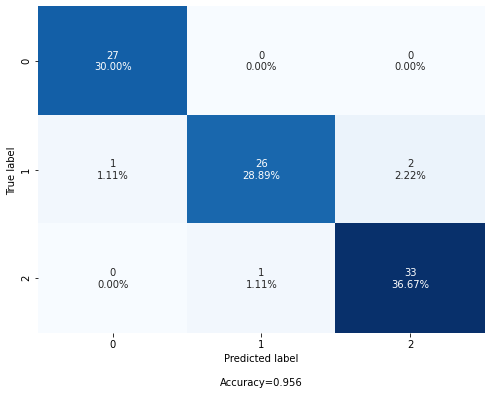

In [ ]:
cf_matrix_squeezenet = confusion_matrix(l, p_v_squeezenet, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_squeezenet ,figsize=(8,6), cbar=False)

#Vgg16 confusion matrix

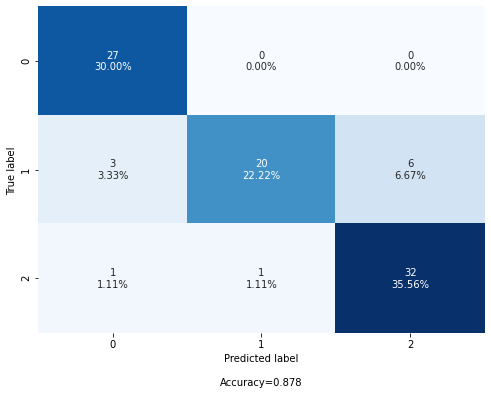

In [ ]:
cf_matrix_vgg = confusion_matrix(l, p_v_vgg, labels=[0, 1, 2])
 
make_confusion_matrix(cf_matrix_vgg ,figsize=(8,6), cbar=False)

Text(0, 0.5, 'Model Accuracy')

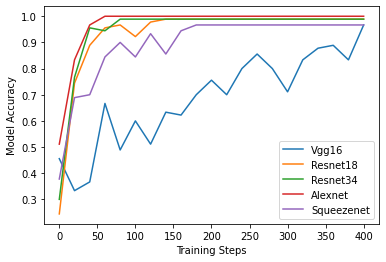

In [ ]:

Accuracy_resnet18 = [0.2444, 0.7444, 0.8889, 0.9556, 0.9667, 0.9222, 0.9778, 0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889]
Accuracy_resnet34 = [0.3000, 0.7667, 0.9556, 0.9444, 0.9889, 0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889, 0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889,0.9889]
Accuracy_alexnet = [0.5111, 0.8333, 0.9667, 1.0000, 1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000]
Accuracy_squeezenet = [0.3778, 0.6889, 0.7000, 0.8444, 0.9000, 0.8444, 0.9333, 0.8556, 0.9444, 0.9667, 0.9667, 0.9667,0.9667,0.9667,0.9667,0.9667,0.9667,0.9667,0.9667,0.9667,0.9667]
Accuracy_vgg16 =[0.4556, 0.3333, 0.3667, 0.6667, 0.4889, 0.6000, 0.5111, 0.6333, 0.6222, 0.7000, 0.7556, 0.7000, 0.8000, 0.8556, 0.8000, 0.7111, 0.8333, 0.8778, 0.8889, 0.8333, 0.9667]
steps = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400]

plt.plot(steps,Accuracy_vgg16)
plt.plot(steps,Accuracy_resnet18)
plt.plot(steps,Accuracy_resnet34)
plt.plot(steps,Accuracy_alexnet)
plt.plot(steps,Accuracy_squeezenet)
plt.legend(["Vgg16", "Resnet18", "Resnet34", "Alexnet", "Squeezenet" ])

plt.xlabel('Training Steps')
plt.ylabel('Model Accuracy')

Text(0, 0.5, 'Validation Loss')

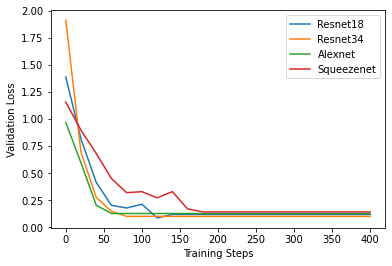

In [ ]:
validation_loss_resnet18 = [1.3895, 0.8173, 0.4161, 0.2043, 0.1796, 0.2146, 0.0880, 0.1201, 0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201]
validation_loss_resnet34 = [1.9144, 0.6943, 0.2769, 0.1488, 0.1023, 0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023,0.1023]
validation_loss_alexnet = [0.9700, 0.5964, 0.2051, 0.1288, 0.1288,0.1288, 0.1288,0.1288, 0.1288,0.1288,0.1288,0.1288,0.1288,0.1288,0.1288,0.1288,0.1288,0.1288,0.1288,0.1288,0.1288]
validation_loss_squeezenet = [1.1585, 0.8981, 0.6833, 0.4516, 0.3210, 0.3305, 0.2733, 0.3311, 0.1716, 0.1436, 0.1436,0.1436,0.1436,0.1436,0.1436,0.1436,0.1436,0.1436,0.1436,0.1436,0.1436]
validation_loss_vgg16 = [1.0968, 9.5646, 36.8344, 4.5879, 80.5387, 7.5725, 2.3946, 1.0321, 1.2035, 0.6689, 0.6495, 0.7238, 0.5941, 0.6752, 0.5481, 0.8732, 0.7186, 0.6117, 0.5216, 0.5371, 0.2451]

plt.plot(steps,validation_loss_resnet18)
plt.plot(steps,validation_loss_resnet34)
plt.plot(steps,validation_loss_alexnet)
plt.plot(steps,validation_loss_squeezenet)
plt.legend(["Resnet18", "Resnet34", "Alexnet", "Squeezenet" ])

plt.xlabel('Training Steps')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Loss')

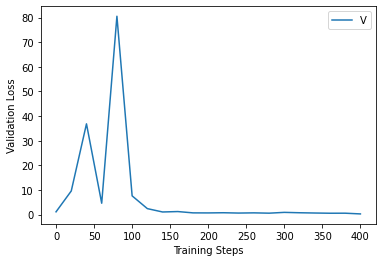

In [ ]:
plt.plot(steps,validation_loss_vgg16)
plt.legend("Vgg16")
plt.xlabel('Training Steps')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Loss')

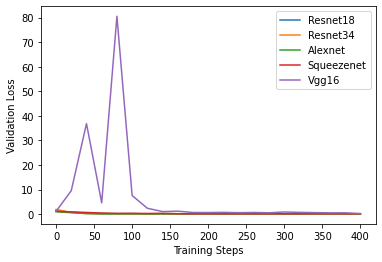

In [ ]:
plt.plot(steps,validation_loss_resnet18)
plt.plot(steps,validation_loss_resnet34)
plt.plot(steps,validation_loss_alexnet)
plt.plot(steps,validation_loss_squeezenet)
plt.plot(steps,validation_loss_vgg16)
plt.legend(["Resnet18", "Resnet34", "Alexnet", "Squeezenet","Vgg16"])

plt.xlabel('Training Steps')
plt.ylabel('Validation Loss')